In [3]:
from uuid import uuid4
from datasets import load_dataset

import tiktoken
import tokenizers
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams


qclient = QdrantClient(host="localhost", port=6334)
# embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L12-v2")

# collection_name = "frugalaichallenge-text-train-multilingual-bge"
collection_name = "frugalaichallenge-text-train"

collections = [collection.name for collection in qclient.get_collections().collections]
print(collections)
if collection_name not in collections:
    qclient.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

vector_store = QdrantVectorStore(
    client=qclient,
    collection_name=collection_name,
    embedding=embedding_model,
)

if collection_name not in collections:
    ds = load_dataset("./data/QuotaClimat___frugalaichallenge-text-train", cache_dir="data")
    tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

    documents = []
    # llama_tokenizer = tokenizers.Tokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct-q4_0")

    for record in ds["train"]:
        metadata = {k: v for k, v in record.items() if k != "quote"}
        metadata["n_tokens_gpt"] = len(tokenizer.encode(record["quote"]))
        # metadata["n_tokens_llama"] = len(llama_tokenizer.tokenize(record["quote"]))
        documents.append(Document(page_content=record["quote"], metadata=metadata))

    uuids = [str(uuid4()) for _ in range(len(documents))]

    vector_store.add_documents(documents=documents, ids=uuids)

['frugalaichallenge-text-train']


In [4]:
results = vector_store.similarity_search("The world has not gotten warmer", k=2)

for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* oh yeah , the global temperature trend has not warmed for 19 years . [{'label': '1_not_happening', 'source': 'FLICC', 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset', 'language': 'en', 'subsource': 'jintrain', 'id': None, '__index_level_0__': 1098, 'n_tokens_gpt': 15, '_id': 'ac447842-acca-4ecd-805f-b7f87764fab1', '_collection_name': 'frugalaichallenge-text-train'}]
* global warming doesn't exist -- or at least hasn't for 19 years [{'label': '1_not_happening', 'source': 'FLICC', 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset', 'language': 'en', 'subsource': 'jintrain', 'id': None, '__index_level_0__': 636, 'n_tokens_gpt': 13, '_id': 'cec6b357-e1a8-4516-bd3d-66ea1679e1df', '_collection_name': 'frugalaichallenge-text-train'}]


In [5]:
import json

from langchain.tools import tool

qdrant_retriever = vector_store.as_retriever(search_kwargs={"k": 5})


@tool(name_or_callable="qdrant_retriever")
def qdrant_retriever_tool(query: str):
    """
    Example quotes containing different levels of climate change desinformation, separated in different categories:
    - 0_accepted: No relevant environmental disinformation claim detected.
    - 1_not_happening: Global warming is not happing. Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening.
    - 2_not_human: Greenhouse gases from humans are not the causing climate change.
    - 3_not_bad: The impacts of climate change will not be bad and might even be beneficial.
    - 4_solutions_wont_work: Climate solutions are harmful or unnecessary.
    - 5_science_is_unreliable: Climate science is uncertain, unsound, unreliable, or biased.
    - 6_scientists_are_biased: Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.
    """
    results = qdrant_retriever.invoke(query)
    return json.dumps(
        [{"quote": res.page_content, "label": res.metadata["label"]} for res in results]
    )


display(json.loads(qdrant_retriever_tool.invoke("The world has not gotten warmer")))

[{'quote': 'oh yeah , the global temperature trend has not warmed for 19 years .',
  'label': '1_not_happening'},
 {'quote': "global warming doesn't exist -- or at least hasn't for 19 years",
  'label': '1_not_happening'},
 {'quote': 'In the most recent 5,000-year period, there have been numerous periods of distinct global warming and global cooling. However, the overall long-term climatic trend indicates that the earth has been getting cooler, not warmer,',
  'label': '1_not_happening'},
 {'quote': 'The world has not warmed up very much since the millennium. Twelve years is a reasonable time it (the temperature) has stayed almost constant, whereas it should have been rising carbon dioxide is rising, no question about that.',
  'label': '1_not_happening'},
 {'quote': 'While evidence seems to indicate that we have been warming up nicely for the past several hundred years, at present we may be in a slight cooling trend. There has been no global warming for almost 15 years.',
  'label': '

Agent structure:

1. Classify as relevant for the environmental disinformation. (n)
2. Return None if classified as not relevant, else point 3. (ce)
3. Claim extraction from the text (extract one claim from the text). (n)
4. Retrieve similar examples (n)
5. Classify text and claim (n)
6. Check if llm agrees with the following extraction. (n)
7. If yes return classification (ce + n)
8. If not extract another claim that is more representative (ce + n)
9. Back to point 4 (e)

In [47]:
from typing import Annotated, Callable, Dict, List, Literal, Optional, Sequence, Any

from langchain import hub
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, ConfigDict, Field
from typing_extensions import TypedDict
from json import JSONDecodeError


def most_frequent(List):
    return max(set(List), key=List.count)


class DocumentRelevance(BaseModel):
    """Binary score for relevance check."""

    relevant: str = Field(description="Relevance: 'yes' or 'no'")


class DesinformationClassification(BaseModel):
    """Classification of the text as relevant for environmental disinformation."""

    relevant: str = Field(description="Disinformation classification: 'yes' or 'no'")


class ClassificationCheck(BaseModel):
    """Check if the classification is correct."""

    correct: str = Field(description="Correctness: 'yes' or 'no'")


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    senders: Annotated[Sequence[str], add_messages]


class Rag(BaseModel):
    model: BaseChatModel
    tools: List[Callable]
    graph: StateGraph
    verbose: Optional[bool] = True

    model_config = ConfigDict(arbitrary_types_allowed=True)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # nodes
        # retriever_tool = ToolNode(tools=self.tools)
        self.graph.add_node("claim_extractor", self.claim_extractor)
        self.graph.add_node("rag_tool", self.rag_tool)
        self.graph.add_node("claim_classificator", self.claim_classificator)
        # self.graph.add_node("double_check", self.double_check)
        self.graph.add_node("returner", self.returner)

        # edges
        # start generation
        self.graph.add_edge(START, "claim_extractor")
        self.graph.add_edge("claim_extractor", "rag_tool")
        self.graph.add_edge("rag_tool", "claim_classificator")
        self.graph.add_edge("claim_classificator", "returner")
        self.graph.add_edge("returner", END)

    def __print(self, *args, **kwargs):
        """Internal print used to print if verbose is set"""
        if self.verbose:
            print(*args, **kwargs)

    def compile(self):
        """Compiles the graph into an executable agent"""
        return self.graph.compile()

    def classificator(self, state: AgentState):
        """
        Classify the text as relevant for the environmental disinformation.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages"""
        self.__print("----- Classifying text -----")

        prompt = PromptTemplate(
            template="""
                You are an assistant in a climate change media study group. The group analyses media transcripts related 
                to climate change and its impacts. You mission is to examine very carefully the transcripts that are givrn to you
                and judge whether or not they are related to climate change. For this task you are not required to pass a 
                judgement on the transcript in question, just judge whether it talks about climate change in any way.
                The text might also be talking about economic or social policies that are somehow related to climate change
                (for example the 'Green Deal' or the 'Paris Agreement'), these count as transcripts related to climate change.
                Keep in mind that a lot of the texts are not perfectly transcribed so watch out for typos and other errors.

                Give a binary score 'yes' or 'no' score to indicate whether the contains mentions of climate change.
                Here is the transcript: {text}
                REMEMBER TO REPLY ONLY 'yes' or 'no'. Do NOT EXPLAIN ! \n 
                Answer:
            """,
            input_variables=["text"],
        )
        chain = prompt | self.model

        messages = state["messages"]
        last_message = messages[0]

        text = last_message.content

        reply = chain.invoke({"text": text})
        classification = DesinformationClassification(relevant=reply.content).relevant
        self.__print(f"Decision: Concerns Climate? {classification}")
        return {"messages": [classification], "senders": ["classificator"]}

    def classificator_edge(
        self, state: AgentState
    ) -> Literal["claim_extractor", "none_returner"]:
        """
        Determines whether the text contains environmental or climate change disinformation.

        Args:
            state (messages): The current state

        Returns:
            str: A decision for whether the documents are relevant or not
        """
        if state["messages"][-1].content == "yes":
            return "claim_extractor"
        else:
            self.__print("----- Return None -----")
            return "none_returner"

    def none_returner(self, state: AgentState) -> Dict[str, List[Any]]:
        return {"messages": ["None"], "senders": ["none_returner"]}

    def claim_extractor(self, state: AgentState):
        """
        Extracts a claim from the text.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        self.__print("----- Extract claim -----")
        template = """
                You are a climate disinformation assistant trying to identify claims in media transcripts
                related to disinformation (voluntary spread of fake news) or misinformation (unvoluntary repetition
                of incorrect information). You will be given a text transcript.
                Extract one claim from the text that captures the main concepts expressed in the text without reformulating.
                If no claim is present, return "no_claim".
                Here is the transcript: {text}
            """
        messages = state["messages"]
        initial_message = messages[0]
        text = initial_message.content

        template = (
            template
            + "\nREMEMBER TO REPLY WITH ONLY ONE CLAIM. Do NOT EXPLAIN ! IF NO CLAIM IS PRESENT, RETURN 'no_claim'.\nAnswer:"
        )
        prompt = PromptTemplate(template=template, input_variables=["text"])
        chain = prompt | self.model

        reply = chain.invoke({"text": text})
        claim = reply.content
        response = json.dumps({"claim": claim, "text": text})
        self.__print(claim)
        return {"messages": [response], "senders": ["claim_extractor"]}
    
    def rag_tool(self, state: AgentState):
        self.__print("----- Classificator Retrieve similar records -----")

        messages = state["messages"]
        last_message = json.loads(messages[-1].content)
        text = last_message["text"]
        examples = qdrant_retriever_tool.invoke(text)
        examples_print = "\n".join([f"*{record['label']}: {record['quote']}" for record in json.loads(examples)])
        self.__print("Found:")
        self.__print(examples_print)
        return {"messages": [examples], "senders": ["rag_tool"]}

    def claim_classificator(self, state: AgentState):
        """
        Classifies the claim according to the pre-defined categories (CARDS) using majority voting.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        self.__print("----- Classify Claim -----")

        messages = state["messages"]
        last_message = json.loads(messages[-2].content)
        text = last_message["text"]
        claim = last_message["claim"]

        examples = self.load_json_string(messages[-1].content, keys=["quote", "label"])
        classes = []
        for record in examples:
            classes.append(record["label"])
        # examples_str = "\n".join(
        #     [
        #         f"Claim: {example['quote']}\nLabel: {example['label']}\n"
        #         for example in examples
        #     ]
        # )

        claim_classification = most_frequent(classes)
        response = json.dumps(
            {"classification": claim_classification, "text": text, "claim": claim},
        )
        self.__print("CARDS Classification:")
        self.__print(claim_classification)
        return {"messages": [response], "senders": ["claim_classificator"]}

    def returner(self, state: AgentState):
        """
        Returns the final conclusion after the double check.
        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        self.__print("----- Return Result -----")
        self.__print(state["messages"][-1].content)
        return {"messages": [state["messages"][-1].content], "senders": ["returner"]}

    def load_json_string(self, json_string: str, keys: List[str], n_iter=1, max_iter=5):
        """Recursive function that formats the string into proper json format"""
        if not json_string.endswith("}") and json_string.startswith("{"):
            json_string = json_string + "}"
        if not json_string.endswith("]") and json_string.startswith("["):
            json_string = json_string + "]"
        try:
            return json.loads(json_string)
        except JSONDecodeError as e:
            if n_iter > max_iter:
                print(json_string)
                raise e
            prompt = PromptTemplate(
                template="""
                    Correct the following string into a proper json string. Remove any markdown or other formatting,
                    for example:
                    ```json
                    {
                        "key1": "value1",
                        "key2": "value2"
                    }
                    ```
                    becomes:
                    {
                        "key1": "value1",
                        "key2": "value2"
                    }
                    ; and:
                    {
                        "key_1": "value_1"
                        "key_2": "value_2"
                    }
                    becomes:
                    {
                        "key_1": "value_1",
                        "key_2": "value_2"
                    }
                    Here is the string:
                    {{json_string}}
                    Here are the following keys for the json document:
                    {{keys}}
                """,
                # Claim: {claim}
                template_format="jinja2",
            )
            chain = prompt | self.model
            chain.invoke({"json_string": json_string, "keys": keys})
            return self.load_json_string(json_string, keys, n_iter=n_iter + 1)


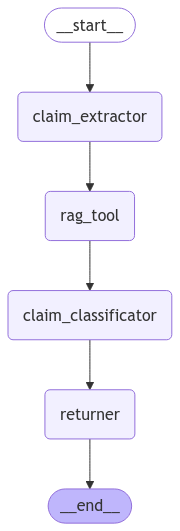

In [48]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()

# agent = Rag(
#     model=ChatOllama(model="llama3.1:8b", temperature=0),
#     tools=[qdrant_retriever_tool],
#     verbose=True,
#     graph=StateGraph(AgentState),
# ).compile()
agent = Rag(
    model=ChatOpenAI(model_name="gpt-4o-mini", temperature=0),
    tools=[qdrant_retriever_tool],
    verbose=True,
    graph=StateGraph(AgentState),
).compile()

agent

In [49]:
import pandas as pd

data = pd.read_parquet("../../data/raw/4_channels_predictions_09_2023_09_2024.parquet")

data.text.head()

id
1dcd4b454f8bac42440259ce26a1a2192051186bb5728be489dc654a9a967d1d    <unk> <unk> <unk> <unk> aerosmith en janvier m...
0eb5805fa23e0819f817ea10fe1fccd19e61e40a1239cc93f701fd56bd8ea66f    la très grande majorité d'entre eux ne connais...
b6d54aefb250671e7754a688411ce9e68badcad88a665be3de78996d13b74fd2    mais titeuf ne vieillit pas le monde change ti...
23c2d3b292d9ab0fb0d0b2b8c34f3b88708c79ffab2d6659accf565ba61f48ae    dû travailler très vite le journal arrive à no...
71df0ce2b34afa23391d8e31d35ccd213ae2a881b7ce412813a06a60a2e47d3c    pas avoir lieu ni même européens existait ni l...
Name: text, dtype: object

In [ ]:
text = data.iloc[35]["text"]

result = agent.invoke(
    {
        "messages": [
            ("user", text),
        ]
    }
)

----- Extract claim -----
La rentrée scolaire ne sera pas décalée au dix-huit septembre.
----- Classificator Retrieve similar records -----
Found:
*6_proponents_biased: The emails showed as well that these senior members were quite happy to discuss ways and means of controlling the research journals so as to deny publication of any material that goes against the orthodox dogma. The ways and means included the sacking of recalcitrant editors.
*0_not_relevant: EP 90619-900 – Porto Alegre, RS, BrasilFone: +55(51) 3384-7158 e 3384-6893E-mail:
*6_proponents_biased: These [FoI] documents expose once again the double standards promoted by…the , who demand absolute transparency from everybody except themselves…The  was the most strident critic during the ‘Climategate’ row of the standards of transparency practised by the University of East Anglia, yet it simply refuses to disclose basic information about its own secretive operations, including the identity of its funders.
*6_proponents_biased:

In [51]:
df = pd.read_excel("/Users/giuseppeguarino/Documents/d4g/climateguard/data/annotated/4_channels_review_09_2023_09_2024.xlsx")

In [52]:
df = df.drop(df.loc[df.cards_ground_truth.isna()].index)
df


,id,channel_name,start,text,quote,claim,analysis,context,cards,cards_ground_truth,quote_is_correct,commentaire_cards,commentaire_quote,Highlight
0,52061c3902c0257c7bfae7086ae50ea3998fea4204bcd6...,europe1,2023-09-08 19:34:00,Ce n'est pas seulement qu'ils ne les utilisent...,les climatologues ne croient plus leurs termes...,Les climatologues ne croient plus leurs termes...,Cette affirmation pourrait créer un doute sur ...,L'intervenant mentionne une perte de confiance...,5_science_uncertain,0_accepted,True,NaN,termes honnêtes = thermomètre ??,NaN
1,34a41bf34b35ee91fc147601fb8c21a366a2f568b9060b...,europe1,2023-09-15 19:30:00,"Jusqu'au trente septembre, détaille Sofia au q...",Il y a beaucoup de soldats poneys menteurs à t...,Il y a beaucoup de soldats poneys menteurs à t...,Cette allégation semble suggérer que le réchau...,"Lors d'une conférence de presse au Vietnam, le...",5_science_uncertain,0_accepted,True,"Contexte spécifique de la phrase, les mots de ...",NaN,NaN
2,0fb8db32982baea27fa4a92220e76331e703d61852c0e8...,europe1,2023-09-20 07:50:00,On tente d'échapper à une tempête de pluie d'a...,tempête de pluie d'acide mortelle selon l'inrs...,tempête de pluie d'acide mortelle enregistrée ...,L'allégation mentionne une tempête de pluie d'...,Dans une discussion sur un film catastrophe éc...,1_its_not_happening,0_accepted,True,"Contexte spécifique de la phrase, la claim men...",NaN,NaN
3,4792f93c6614b1e7ef39e301cc6c1d0f4d3d18b9421cc3...,europe1,2023-10-02 07:54:00,"Les Français n'arrivent pas à se loger, c'est ...",Ça va de l'interdiction des avions d'affaires ...,Diminuer le nombre de vaches et contrôler les ...,Cette affirmation présente des mesures qui n'o...,L'interlocuteur mentionne plusieurs mesures ex...,3_impacts_not_bad,6_proponents_biased,True,NaN,NaN,NaN
4,74c05fdbca4aeffb643abf0de486b57f8299051d4ef71b...,europe1,2023-10-05 19:54:00,Le réchauffement climatique a été collecté à G...,on ne peut pas faire le lien directement avec ...,On ne peut pas faire le lien directement avec ...,Cette assertion minimise le consensus scientif...,Luc Moreau énonce lui-même qu'il est difficile...,2_humans_not_the_cause,2_humans_not_the_cause,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,22d30e47c43d8defe1bdab51e6e4c6374ba982d76de889...,tf1,2024-04-23 20:36:00,"Plus chaud de ces dix dernières années, le tem...",Il n'y a plus ni eau ni printemps.,Il n'y a plus ni eau ni printemps.,Cette affirmation semble exagérée et pourrait ...,L'orateur évoque un changement climatique qui ...,1_its_not_happening,0_accepted,False,NaN,"Problème de retranscription, plus automne ni p...",NaN
541,58feacdc4a4d31023a87bce158ee902d37076d9f5562f3...,tf1,2024-04-28 20:40:00,"Aujourd'hui, ce fameux pacte d'immigration qui...",ce tsunami de normes de contraintes de taxe qu...,Le pacte vert européen organise la décroissance.,Cette affirmation attribue une intention de dé...,Lors d'un discours critique à l'égard des poli...,4_solutions_harmful_unnecessary,4_solutions_harmful_unnecessary,True,NaN,NaN,NaN
542,6d39a0d45c359fd2183c0f1f001b76c4b60d283240e5c3...,tf1,2024-06-16 18:04:00,"Avec l'aide de nos fournisseurs, si il s'avère...",l'entreprise n'a pas voulu nous dire combien d...,L'huile de palme serait aujourd'hui une soluti...,Cette allégation semble minimiser les impacts ...,Dans un débat sur les pratiques de certains fo...,4_solutions_harmful_unnecessary,0_accepted,True,Potentiellement plutôt du greenwashing,NaN,NaN
543,0718ef4df3559735ad33436f7e1e39802a71d923cbc0b9...,tf1,2024-07-21 17:14:00,"En France, plusieurs millions de maisons sont ...",le dérèglement climatique phénomène naturel.,Le dérèglement climatique est un phénomène nat...,Cette affirmation contredit le consensus scien...,Une affirmation selon laquelle les changements...,2_humans_not_the_cause,0_accepted,True,Légitime mais tellement court que ça a l'air d...,NaN,NaN


In [53]:
text = df.iloc[52]["text"]

print(f"Ground Truth: {df.iloc[52]['cards_ground_truth']}")

result = agent.invoke(
    {
        "messages": [
            ("user", text),
        ]
    }
)
result

Ground Truth: 0_accepted
----- Extract claim -----
Une étude d'impact sur la voiture électrique, ça obligeait à poser clairement la réalité : nous avons besoin de produire beaucoup plus de façon stable et décarbonée.
----- Classificator Retrieve similar records -----
Found:
*6_proponents_biased: Without a hearing, German officials have fined her and demanded costs on the ground that in her devastatingly effective videos she has dared to question the Party Line about what officialdom profiteers by presenting as ‘dangerous’ manmade global warming,” Monckton claimed at JunkScience s a result of this arbitrary and capricious prosecution and conviction without trial, Naomi has had her earnings cut off. Please donate securely and directly to her Patreon account at https://www.patreon.com/naomiseibtmy. May I suggest at least $10 per month? That would be a real life-saver, and would enable Naomi to continue her valuable work.
*6_proponents_biased: Without a hearing, German officials have fined

{'messages': [HumanMessage(content="Elle a la fâcheuse habitude de penser qu'elle peut fixer un objectif sur un coin de table et que cela suffit à faire une politique publique, sans jamais demander comment ni avec quels effets l'intendance suivra. Elle a fait exactement la même chose avec l'agriculture. On en a beaucoup parlé ici. La seconde raison pour laquelle elle a soigneusement évité d'étudier l'impact, c'est qu'elle pressentait que les réponses obligeraient à confronter la pensée magique à la réalité, une réalité qui supposait de tordre le cou à un certain nombre de dogmes écologiques. Et ça, ça n'a pas bonne presse. Alors, ces dogmes, en l'occurrence, viennent d'abord du dogme de la décroissance, qui continue à façonner la pensée de toute une partie de la gauche européenne. Pour transformer le parc automobile, il faut construire de grandes usines de pièces de batteries. Or, il est devenu quasiment impossible d'en implanter en France et dans toute une partie de l'Europe. Elles fo

In [54]:
df.cards_ground_truth.value_counts()


cards_ground_truth
0_accepted                         118
4_solutions_harmful_unnecessary     88
6_proponents_biased                 70
1_its_not_happening                 31
5_science_uncertain                 22
2_humans_not_the_cause              19
3_impacts_not_bad                   15
7_fossil_fuels_needed                7
Name: count, dtype: int64

In [55]:
import tqdm
from tqdm.asyncio import tqdm as atqdm
import asyncio
from functools import wraps
from langgraph.errors import GraphRecursionError

agent = Rag(
    model=ChatOpenAI(model_name="gpt-4o-mini"),
    # model=ChatOllama(model="llama3.1:8b", temperature=0),
    tools=[qdrant_retriever_tool],
    verbose=False,
    graph=StateGraph(AgentState),
).compile()

async def arun_agent(text, id, sem):
    async with sem:
        try:
            result = await agent.ainvoke({"messages": [("user", text)]}, {"recursion_limit": 10})
            return id, result["messages"][-1].content
        except GraphRecursionError:
            return id, "None"
        
def run_agent(text, id):
    result = agent.invoke({"messages": [("user", text)]}, {"recursion_limit": 10})
    return id, result["messages"][-1].content
    

semaphore = asyncio.Semaphore(30)

async def amain(sem):
    results = await atqdm.gather(*[arun_agent(row.text, row.id, sem) for row in df.itertuples()])
    return results

def main():
    results = [run_agent(row.text, row.id) for row in tqdm.tqdm(df.itertuples(), total=len(df))]
    return results

results = await amain(semaphore)
# results = main()


100%|██████████| 370/370 [00:23<00:00, 16.07it/s]


In [56]:
results

[('52061c3902c0257c7bfae7086ae50ea3998fea4204bcd6628588e41d71340dfc',
  '{"classification": "4_solutions_harmful_unnecessary", "text": "Ce n\'est pas seulement qu\'ils ne les utilisent pas, mais en plus, cela nous fait croire qu\'il n\'y en a pas. Cela cr\\u00e9e des primes et tout le monde, parmi ces mille cinq cents solutions, il y a des id\\u00e9es, des avanc\\u00e9es en termes d\'\\u00e9nergie. On vient d\'en parler et vous avez cit\\u00e9 notamment l\'id\\u00e9e de prendre la chaleur des parkings pour chauffer les maisons. Ces solutions sont l\\u00e0 parce que le vingt et uni\\u00e8me si\\u00e8cle a d\\u00e9cid\\u00e9 d\'une nouvelle donne pour l\'\\u00e9nergie. On se d\\u00e9barrasse du fossile qui a fait tourner les voitures, une fabuleuse invention du XXe si\\u00e8cle, ainsi que les usines, les trains et toutes sortes de choses. Mais, Bertrand Piccard, c\'est un peu le chien qui se mord la queue. Bien entendu, on aurait d\\u00fb faire la transition avant, mais maintenant que la

In [57]:
ids = []
records = []
for idx, record in results:
    if record != "None":
        ids.append(idx)
        records.append(json.loads(record))
results_df = pd.DataFrame(records, index=ids)
display(results_df.head())


,classification,text,claim
52061c3902c0257c7bfae7086ae50ea3998fea4204bcd6628588e41d71340dfc,4_solutions_harmful_unnecessary,Ce n'est pas seulement qu'ils ne les utilisent...,Le changement climatique ne vient pas simpleme...
34a41bf34b35ee91fc147601fb8c21a366a2f568b9060bbb629698dfd9319801,0_not_relevant,"Jusqu'au trente septembre, détaille Sofia au q...",no_claim
0fb8db32982baea27fa4a92220e76331e703d61852c0e8d95550ef6853ffd842,0_not_relevant,On tente d'échapper à une tempête de pluie d'a...,Des pluies mille fois plus acides que la norma...
4792f93c6614b1e7ef39e301cc6c1d0f4d3d18b9421cc3a9b18aa5c7581c9e02,5_science_unreliable,"Les Français n'arrivent pas à se loger, c'est ...",Une certaine écologie oscille sans cesse entre...
74c05fdbca4aeffb643abf0de486b57f8299051d4ef71b58b532791a33aba423,0_not_relevant,Le réchauffement climatique a été collecté à G...,Il y a quand même un réchauffement à ces altit...


In [58]:
df.to_csv("results_rag_only.csv")

In [59]:
results_df.classification.str[0].value_counts()

classification
0    171
4     70
6     58
5     22
2     20
3     12
7     10
1      7
Name: count, dtype: int64

In [60]:
comparison_df = df.set_index("id")[["text", "quote", "claim", "cards_ground_truth"]].merge(
    results_df["classification"],
    how="left",
    right_index=True,
    left_index=True
).fillna("0_accepted")



In [61]:
display(comparison_df.cards_ground_truth.str[0].value_counts())
display(comparison_df.classification.str[0].value_counts())

cards_ground_truth
0    118
4     88
6     70
1     31
5     22
2     19
3     15
7      7
Name: count, dtype: int64

classification
0    171
4     70
6     58
5     22
2     20
3     12
7     10
1      7
Name: count, dtype: int64

In [62]:
(comparison_df.cards_ground_truth.str[0] == comparison_df.classification.str[0]).sum() / len(comparison_df)

np.float64(0.2756756756756757)

In [63]:
((comparison_df.cards_ground_truth.str[0]=="0") == (comparison_df.classification.str[0]=="0")).sum() / len(comparison_df)

np.float64(0.527027027027027)

In [64]:
from sklearn.metrics import classification_report

print(classification_report(
    y_pred=comparison_df.classification.str[0],
    y_true=comparison_df.cards_ground_truth.str[0],
))

              precision    recall  f1-score   support

           0       0.33      0.48      0.39       118
           1       0.14      0.03      0.05        31
           2       0.15      0.16      0.15        19
           3       0.08      0.07      0.07        15
           4       0.34      0.27      0.30        88
           5       0.00      0.00      0.00        22
           6       0.24      0.20      0.22        70
           7       0.20      0.29      0.24         7

    accuracy                           0.28       370
   macro avg       0.19      0.19      0.18       370
weighted avg       0.26      0.28      0.26       370



In [65]:
import numpy as np

comparison_df["macro_category_ground_truth"] = "accepted"
comparison_df.loc[comparison_df.cards_ground_truth.str[0].isin(["1", "2", "3", "5"]), "macro_category_ground_truth"] = "disinformation"
comparison_df.loc[comparison_df.cards_ground_truth.str[0].isin(["4", "6", "7"]), "macro_category_ground_truth"] = "inaction"

comparison_df["macro_category_prediction"] = "accepted"
comparison_df.loc[comparison_df.classification.str[0].isin(["1", "2", "3", "5"]), "macro_category_prediction"] = "disinformation"
comparison_df.loc[comparison_df.classification.str[0].isin(["4", "6", "7"]), "macro_category_prediction"] = "inaction"


display(comparison_df.cards_ground_truth.str[0].value_counts())
display(comparison_df.classification.str[0].value_counts())
display(comparison_df.macro_category_ground_truth.value_counts())
display(comparison_df.macro_category_prediction.value_counts())

cards_ground_truth
0    118
4     88
6     70
1     31
5     22
2     19
3     15
7      7
Name: count, dtype: int64

classification
0    171
4     70
6     58
5     22
2     20
3     12
7     10
1      7
Name: count, dtype: int64

macro_category_ground_truth
inaction          165
accepted          118
disinformation     87
Name: count, dtype: int64

macro_category_prediction
accepted          171
inaction          138
disinformation     61
Name: count, dtype: int64

In [66]:
print(classification_report(
    y_true=comparison_df.macro_category_ground_truth,
    y_pred=comparison_df.macro_category_prediction,
))

                precision    recall  f1-score   support

      accepted       0.33      0.48      0.39       118
disinformation       0.41      0.29      0.34        87
      inaction       0.51      0.43      0.47       165

      accuracy                           0.41       370
     macro avg       0.42      0.40      0.40       370
  weighted avg       0.43      0.41      0.41       370



In [67]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    y_true=comparison_df.cards_ground_truth.str[0],
    y_pred=comparison_df.classification.str[0]
)

cm_macro = confusion_matrix(
    y_true=comparison_df.macro_category_ground_truth,
    y_pred=comparison_df.macro_category_prediction
)

In [68]:
import plotly.figure_factory as ff

def plot_confusion_matrix(cm, labels=None, title='Confusion Matrix', cmap='Blues'):
    cm_text = [[str(y) for y in x] for x in cm]
    if labels is None:
        labels = [str(i) for i in range(len(cm))]
        
    fig = ff.create_annotated_heatmap(
        cm,
        x=labels,
        y=labels,
        colorscale=cmap,
        annotation_text=cm_text
    )
    fig.update_layout(
        title_text='<i><b>Confusion matrix</b></i>',
        #xaxis = dict(title='x'),
        #yaxis = dict(title='x')
    )

    # add custom xaxis title
    fig.add_annotation(
        dict(
            font=dict(
                color="black",
                size=14
            ),
            x=0.5,
            y=-0.15,
            showarrow=False,
            text="Predicted value",
            xref="paper",
            yref="paper"
        )
    )

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    return fig

In [69]:
display(plot_confusion_matrix(cm, labels=None, title='Confusion Matrix', cmap='Blues'))
display(plot_confusion_matrix(cm_macro, labels=["accepted", "disinformation", "inaction"], title='Confusion Matrix', cmap='Blues'))